## Import Modules

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

### Load the Dataset

In [6]:
BASE_DIR = '/content/utkface_aligned_cropped/UTKFace'

In [7]:
# labels - age, gender, ethnicity

image_paths = []
age_labels =[]
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
# convert to dataframe

df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/utkface_aligned_cropped/UTKFace/32_1_...,32,1
1,/content/utkface_aligned_cropped/UTKFace/1_0_2...,1,0
2,/content/utkface_aligned_cropped/UTKFace/4_1_3...,4,1
3,/content/utkface_aligned_cropped/UTKFace/26_1_...,26,1
4,/content/utkface_aligned_cropped/UTKFace/53_0_...,53,0


In [9]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

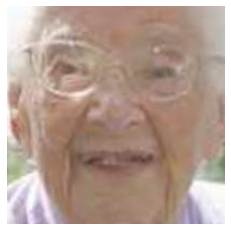

In [14]:
from PIL import Image
img = Image.open(df['image'][10])
plt.axis('off')
plt.imshow(img);

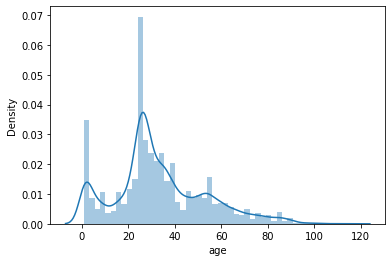

In [15]:
sns.distplot(df['age'])

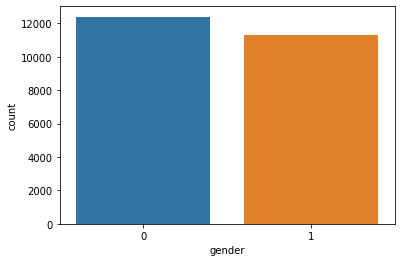

In [16]:
sns.countplot(df['gender'])

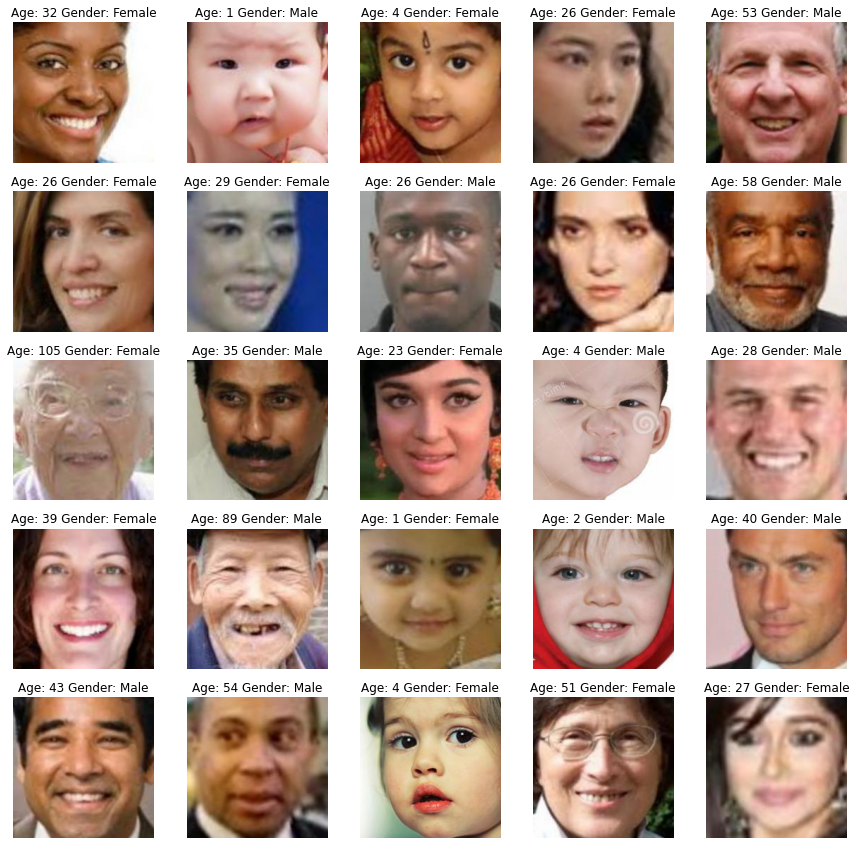

In [17]:
# to display grid of images

plt.figure(figsize=(15,15))
files = df.iloc[:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [20]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [21]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [22]:
X.shape

(23708, 128, 128, 1)

In [23]:
# normalize the images
X = X/255.0

In [24]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [25]:
input_shape = (128, 128, 1)

## Model Creation

In [27]:
inputs = Input((input_shape))

#convolutional layer
conv_1 = Conv2D(32, kernel_size=(3,3), activation = 'relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation = 'relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation = 'relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation = 'relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten() (maxp_4)

#fully connected layers

dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation= 'sigmoid', name = 'gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name = 'age_out') (dropout_2)

model = Model(inputs = [inputs], outputs = [output_1, output_2])

model.compile(loss = ['binary_crossentropy', 'mae'], optimizer='SGD', metrics=['accuracy'])

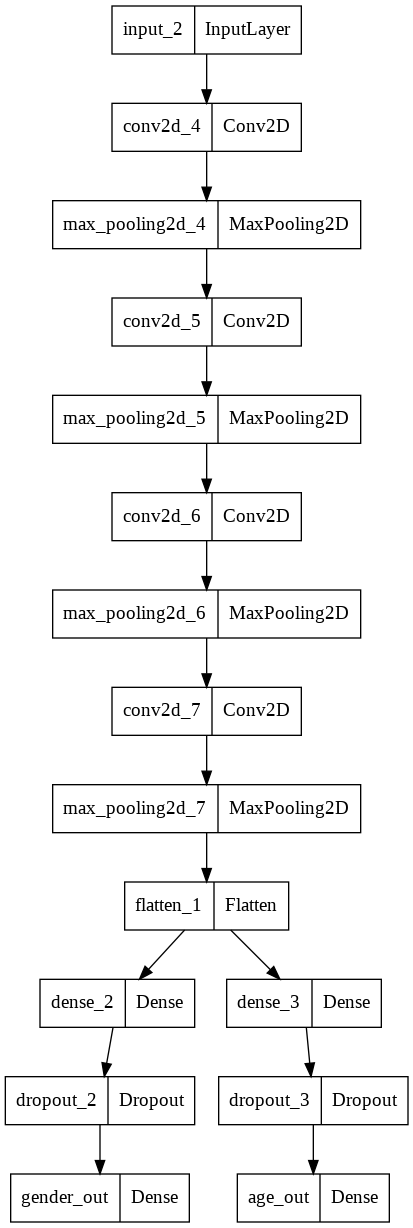

In [28]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [30]:
#train model

history = model.fit(x= X, y= [y_gender, y_age], batch_size = 32, epochs= 30, validation_split= 0.2)

Epoch 1/30
593/593 [==============================] - 30s 24ms/step - loss: 18.6239 - gender_out_loss: 0.6965 - age_out_loss: 17.9274 - gender_out_accuracy: 0.5090 - age_out_accuracy: 0.0474 - val_loss: 17.4501 - val_gender_out_loss: 0.6842 - val_age_out_loss: 16.7659 - val_gender_out_accuracy: 0.6181 - val_age_out_accuracy: 0.0396
Epoch 2/30
593/593 [==============================] - 13s 22ms/step - loss: 15.6394 - gender_out_loss: 0.6707 - age_out_loss: 14.9688 - gender_out_accuracy: 0.5849 - age_out_accuracy: 0.0493 - val_loss: 16.8439 - val_gender_out_loss: 0.6491 - val_age_out_loss: 16.1948 - val_gender_out_accuracy: 0.6278 - val_age_out_accuracy: 0.0396
Epoch 3/30
593/593 [==============================] - 13s 22ms/step - loss: 14.8367 - gender_out_loss: 0.6034 - age_out_loss: 14.2333 - gender_out_accuracy: 0.6777 - age_out_accuracy: 0.0493 - val_loss: 14.2186 - val_gender_out_loss: 0.5029 - val_age_out_loss: 13.7156 - val_gender_out_accuracy: 0.7617 - val_age_out_accuracy: 0.039

## Plot the Results

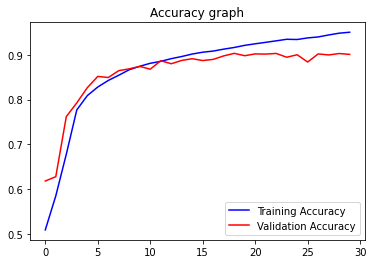

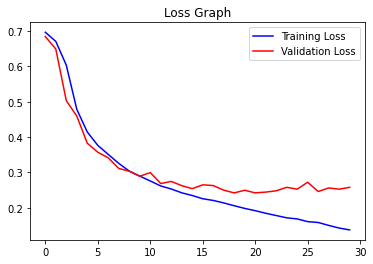

In [32]:
# plot results for gender

acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

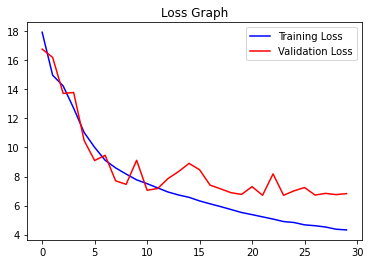

In [33]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Prediction with Test Data

orignal Gender: Male Orignal Age: 18
Predicted Gender: Male Predicted Age: 19


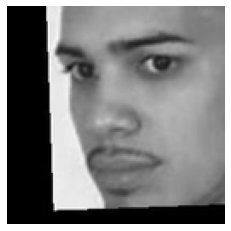

In [34]:
image_index = 125
print('orignal Gender:', gender_dict[y_gender[image_index]], 'Orignal Age:', y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');


orignal Gender: Male Orignal Age: 20
Predicted Gender: Male Predicted Age: 22


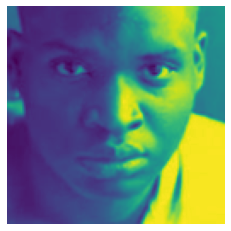

In [35]:
image_index = 1250
print('orignal Gender:', gender_dict[y_gender[image_index]], 'Orignal Age:', y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128));


orignal Gender: Male Orignal Age: 53
Predicted Gender: Male Predicted Age: 52


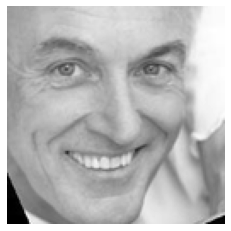

In [36]:
image_index = 100
print('orignal Gender:', gender_dict[y_gender[image_index]], 'Orignal Age:', y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');


orignal Gender: Male Orignal Age: 26
Predicted Gender: Male Predicted Age: 26


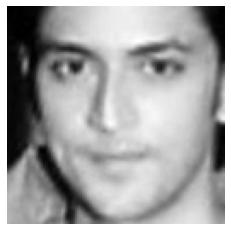

In [37]:
image_index = 3000
print('orignal Gender:', gender_dict[y_gender[image_index]], 'Orignal Age:', y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

orignal Gender: Male Orignal Age: 45
Predicted Gender: Male Predicted Age: 43


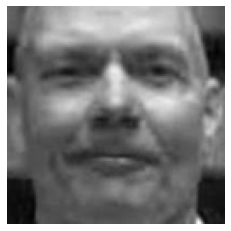

In [44]:
image_index = 1367
print('orignal Gender:', gender_dict[y_gender[image_index]], 'Orignal Age:', y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');